#### Build a Multi-output Model

This notebook demonstrate how to build a multi-output model. The dataset used is from UCI ML Repo.
It's an Energy Efficiency dataset which uses the building features as inputs and has two outputs: *Cooling Load* and *Heating Load*.

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import IPython
import IPython.display

import tensorflow as tf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

#### Let's define some utilities functions

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y2 = data.pop('Y2')
    y1 = np.array(y1)
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()
    
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

#### Let's prepare the data

In [3]:
#Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

df = pd.read_excel(URL, usecols=['X1', 'X2', 'X3', 'X4',  'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'])
df = df.sample(frac=1).reset_index(drop=True).dropna() #For simplicity here we will dropna()
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

train_Y = format_output(train)
test_Y = format_output(test)

norm_train_X = norm(train)
norm_test_X = norm(test)

#### Let's Build the Model

In [4]:
input_layer = Input(shape=len(train.columns))

first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=128)(second_dense)

y2_output = Dense(units=1, name='y2_output')(third_dense)

model = Model(inputs=[input_layer], outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
______________________________________________________________________________________________

#### Parameters setups

In [5]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
             loss={'y1_output':'mse', 'y2_output':'mse'},
             metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                     'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [7]:
#### Let's train and evaluate the model
history = model.fit(norm_train_X, train_Y,
                   epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

IPython.display.clear_output()

In [9]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print(f'Loss = {loss}, Y1_loss = {Y1_loss}, Y1_mse = {Y1_rmse}, Y2_loss = {Y2_loss}, Y2_mse = {Y2_rmse}')

5/5 [==============================] - 0s 3ms/step - loss: 1.4453 - y1_output_loss: 0.3086 - y2_output_loss: 1.1367 - y1_output_root_mean_squared_error: 0.5555 - y2_output_root_mean_squared_error: 1.0662
Loss = 1.4452998638153076, Y1_loss = 0.30857327580451965, Y1_mse = 0.5554937124252319, Y2_loss = 1.1367266178131104, Y2_mse = 1.066173791885376


#### Plot loss and mse

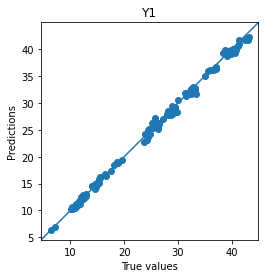

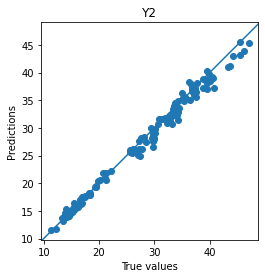

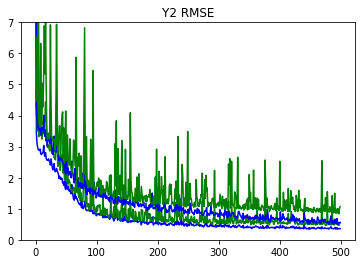

In [19]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')

plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)